In [1]:
# This notebook is used to investigate the differences in PSS/E and ANDES dynamic simulations.

In [2]:

"""
helpful function and imports 
"""

import andes
import numpy as np
import pandas as pd
%matplotlib inline

# import PSSE stuff
# Standard Libraries
import os
import sys
import time

# 3rd Party Libraries
import pandas as pd
import cmath
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


# Function to plot results from the simulation
def plot_simulation_results(output_file, channels):
    chnf_obj = dyntools.CHNF(output_file)
    _, channel_ids, channel_data = chnf_obj.get_data()
    base_frequency = 60.0  # Hz
    
    plt.figure(figsize=(10, 6))
    
    # Assuming channels for generator frequencies are correctly numbered
    
    for ch in channels:
        frequency_deviation = np.array(channel_data[ch])
        time_array = np.array(channel_data['time'])
        actual_frequency = 60.0 * (1 + frequency_deviation)
        
        plt.plot(time_array, actual_frequency, label=f'Channel {ch} Frequency')
    
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title('Generator Frequency Over Time')
    plt.legend()
    plt.grid(True)
    #plt.ylim(59.96, 60.012)  
    plt.show()
    return plt

def plot_temp(output_file, channels):
    chnf_obj = dyntools.CHNF(output_file)
    _, channel_ids, channel_data = chnf_obj.get_data()
    base_frequency = 60.0  # Hz
    
    plt.figure(figsize=(10, 6))
    
    # Assuming channels for generator frequencies are correctly numbered
    
    for ch in channels:
        frequency_deviation = np.array(channel_data[ch])
        time_array = np.array(channel_data['time'])
        actual_frequency = frequency_deviation #60.0 * (1 + frequency_deviation)
        
        plt.plot(time_array, actual_frequency, label=f'Channel {ch} Frequency')
    
    plt.xlabel('Time (s)')
    plt.legend()
    plt.grid(True)
    #plt.ylim(59.96, 60.012)  
    plt.show()
    return plt

def extract_psse_data_to_df(output_file, channels):
    chnf_obj = dyntools.CHNF(output_file)
    _, channel_ids, channel_data = chnf_obj.get_data()
    base_frequency = 60.0  # Base frequency in Hz
    
    # Initialize a dictionary to hold data for DataFrame
    data_dict = {}
    
    # Extract time array (assuming 'time' is the key for time data in channel_data)
    time_array = np.array(channel_data['time'])
    data_dict['Timestamp'] = time_array
    
    # Loop through the specified channels to extract frequency data
    for ch in channels:
        if ch in channel_data:
            # Assuming the data represents frequency deviations, calculate actual frequency
            frequency_deviation = np.array(channel_data[ch])
            actual_frequency = base_frequency * (1 + frequency_deviation)
            data_dict[f'Generator_{ch}_Freq'] = actual_frequency
        else:
            print(f"Channel {ch} not found in the output data.")
    
    # Create a DataFrame from the dictionary
    gen_data_df_psse = pd.DataFrame(data_dict)
    
    return gen_data_df_psse


def plot_generator_frequency(andes_df, psse_df, andes_freq_col, psse_freq_col, andes_label='ANDES Gen 1 Frequency', psse_label='PSS/E Gen 1 Frequency'):

    plt.figure(figsize=(10, 6))

    # Plot ANDES Generator Frequency
    plt.plot(andes_df['Timestamp'], andes_df[andes_freq_col], label=andes_label, linestyle='-', marker='')

    # Plot PSS/E Generator Frequency
    plt.plot(psse_df['Timestamp'], psse_df[psse_freq_col], label=psse_label, linestyle='--', marker='')

    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title( psse_freq_col + 'Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def calculate_mae_between_generators(df1, df2, col1, col2):
    """
    Calculates the Mean Absolute Error (MAE) between specified generator frequency columns
    from two DataFrames after aligning their timestamps represented as floats.

    Parameters:
    - df1, df2: The two pandas DataFrames containing the simulation data with 'Timestamp' as index.
    - col1, col2: The names of the columns in df1 and df2 to compare.

    Returns:
    - mae: The Mean Absolute Error between the two specified columns.
    """
    # Ensure the 'Timestamp' column is the index and it's of float type
    if 'Timestamp' in df1.columns:
        df1.set_index('Timestamp', inplace=True)
    if 'Timestamp' in df2.columns:
        df2.set_index('Timestamp', inplace=True)
    
    df1.index = df1.index.astype(float)
    df2.index = df2.index.astype(float)

    # Remove duplicates by keeping the first occurrence
    df1 = df1[~df1.index.duplicated(keep='first')]
    df2 = df2[~df2.index.duplicated(keep='first')]

    # Find the union of the two DataFrames' indexes after removing duplicates
    common_index = df1.index.union(df2.index)

    # Reindex and interpolate
    df1_interpolated = df1.reindex(common_index).interpolate()
    df2_interpolated = df2.reindex(common_index).interpolate()

    # Calculate MAE
    mae = np.mean(np.abs(df1_interpolated[col1] - df2_interpolated[col2]))
    
    return mae

In [3]:
sim_parameters = {
    "Duration": 10.01000000,
    "Res": 0.001000000,
    "Raw": "./andes_IEEE14.raw",
    "Dyr": "./andes_IEEE14.dyr",
}

The honest Newton method is being used. It will slow down the simulation.
For speed up, set `honest=0` in TDS.config.


<Fault Fault_1>: Applying fault on Bus (idx=2) at t=1.0 sec.
<Fault Fault_1>: Clearing fault on Bus (idx=2) at t=1.2 sec.


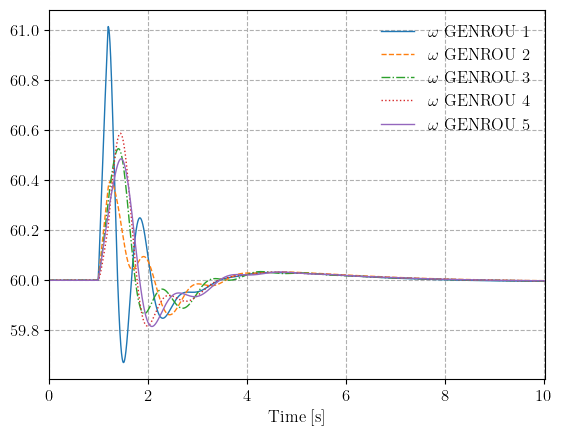

In [5]:
# run the ANDES SIM and save the output, need to use the ANDES_1 conda env (need to fix)

case_raw_path = sim_parameters["Raw"]
case_dyr_path = sim_parameters["Dyr"]

ss = andes.load(case_raw_path, addfile=case_dyr_path, setup=False)

# event 1
ss.add("Fault", dict(bus=2, tf=1.0, tc=1.2))

# event 2
# ss.add('Fault', dict(bus=2,tf=10.0, tc=10.2))

# print("Old VMAX: {}".format(ss.TGOV1.VMAX))
# print("Old VMIN: {}".format(ss.TGOV1.VMIN))


# for i in range(len(ss.TGOV1.VMAX.v)):
#     ss.TGOV1.VMAX.v[i] = 1.1

# for i in range(len(ss.TGOV1.VMIN.v)):
#     ss.TGOV1.VMIN.v[i] = 0.5


ss.setup()  # no `ss.add()` calls are allowed after setup()

ss.PFlow.config.method = "NR"

ss.PFlow.run()
ss.TDS.config.tf = sim_parameters[
    "Duration"
]  # simulate for 3 mins 0 seconds to save time
ss.TDS.config.no_tqdm = 1  # disable progres bar print

ss.TDS.config.method = "trapezoid"
ss.TDS.config.honest = 1
ss.TDS.config.qrt = 1
ss.TDS.config.refresh_event = 1
ss.TDS.config.linsolve = 1
ss.TDS.config.tstep = sim_parameters["Res"]
ss.TDS.run()


# Use the provided method to get timestamps
timestamps = ss.TDS.plotter.t

andes_gen_data = ss.TDS.plotter.get_values(ss.TDS.plotter.find("omega")[0])
# andes_gen_data = ss.TDS.plotter.get_values(ss.TDS.plotter.find('BusFreq')[0])

# Ensure the length of andes_gen_data and timestamps match
assert len(andes_gen_data) == len(timestamps), "Data and timestamps length mismatch."

# Preparing column names for generators
num_generators = andes_gen_data.shape[1]  # Number of columns in andes_gen_data
gen_column_names = [f"Generator_{i+1}_Freq" for i in range(num_generators)]

# Creating the DataFrame
andes_df = pd.DataFrame(data=andes_gen_data, columns=gen_column_names)
andes_df.insert(
    0, "Timestamp", timestamps
)  # Inserting the timestamps as the first column


base_frequency = 60

# Convert the generator speeds from per-unit to Hz
# Skip the first column ('Timestamp') and apply conversion to the rest
for col in andes_df.columns[
    1:
]:  # This skips 'Timestamp' and iterates over generator speed columns
    andes_df[col] = andes_df[col] * base_frequency


fig, ax = ss.TDS.plotter.plot(
    ss.TDS.plotter.find("omega")[0],
    ycalc=lambda x: 60 * x,
    greyscale=True,
    grid=True,
    set_ylim=True,
)

In [6]:
"""
This cell is used to import the required libraries and set up the PSSE environment,
this is a bit more complex than it should because of the way I developed WEC-GRID
"""

# local libraries
from WEC_GRID.utilities.util import read_paths
from WEC_GRID.viz.psse_viz import PSSEVisualizer

# Initialize the PATHS dictionary
PATHS = read_paths()
CURR_DIR = os.path.dirname(os.path.abspath("./"))

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
psse_path = PATHS["psse"]
sys.path.extend(
    [
        os.path.join(psse_path, subdir)
        for subdir in ["PSSPY37", "PSSBIN", "PSSLIB", "EXAMPLE"]
    ]
)
os.environ["PATH"] = (
    os.path.join(psse_path, "PSSPY37")
    + ";"
    + os.path.join(psse_path, "PSSBIN")
    + ";"
    + os.path.join(psse_path, "EXAMPLE")
    + ";"
    + os.environ["PATH"]
)

import psse35

psse35.set_minor(3)
import psspy
import dyntools

psspy.psseinit(50)


_i = psspy.getdefaultint()
_f = psspy.getdefaultreal()
_s = psspy.getdefaultchar()

import matplotlib.pyplot as plt
import numpy as np
import dyntools

    Sets PSSE environment to latest minor version among installed versions of PSSE 35.
    Use psse35.set_minor(n) to set PSSE35 minor version (n) to use.
        Example, for PSSE 35.0.x, use this as: psse35.set_minor(0)

 Input error detected at !
 -m ipykernel_launcher -f C:\Users\alexb\AppData\Roaming\jupyter\runtime\kernel-bde758ed-1409-4033-b666-abbdffe356a1.json
                          !

 PSS(R)E Xplore Version 35
 Copyright (c) 1976-2024
 Siemens Industry, Inc.,
 Power Technologies International                            (PTI)
 This program is a confidential  unpublished  work  created  and  first
 licensed in 1976.  It is a trade secret which is the property of  PTI.
 All use,  disclosure,  and/or reproduction not specifically authorized
 by  PTI  is prohibited.   This  program is protected  under  copyright
 laws  of  non-U.S.  countries  and  by  application  of  international
 treaties.  All  Rights  Reserved  Under  The  Copyright  Laws.

 Could not find entry point ru

In [7]:
import os
import psspy
import time


# Adjust file names to include sim_num for uniqueness
output_file = f"./simulation_output_file.out"
solved_case = f"./solved_case.sav"
final_state = f"./final_state_after_dynamic_sim.sav"


for file_path in [output_file, solved_case, final_state]:
    if os.path.exists(file_path):
        print(f"Deleting existing file: {file_path}")
        os.remove(file_path)


time.sleep(2)

# Assuming case_raw_path and case_dyr_path are defined elsewhere in your script
psspy.read(1, sim_parameters["Raw"])
psspy.dyre_new(dyrefile=sim_parameters["Dyr"])
psspy.fnsl()
# psspy.save(solved_case)

# Setup for dynamic simulation
psspy.cong(0)
psspy.ordr(0)
psspy.fact()
psspy.tysl(0)
psspy.chsb(sid=0, all=1, status=[-1, -1, -1, 1, 7, 0])  # Machine speed

# Start recording to the uniquely named output file
psspy.strt_2(outfile=output_file, snapfile=solved_case)

# Set up the simulation parameters (assumed to be done correctly)
psspy.dynamics_solution_param_2(REALAR3=sim_parameters["Res"])

"""event 1 """
psspy.run(tpause=1)
psspy.dist_bus_fault(ibus=2, string="", basekv=0, busfrac=1.0, r=0.0, x=0.0)

sim_time = 1.2
psspy.run(tpause=sim_time)
psspy.dist_clear_fault(1)


"""event 2"""
psspy.run(tpause=10)
psspy.dist_bus_fault(ibus=2, string="", basekv=0, busfrac=1.0, r=0.0, x=0.0)

psspy.run(tpause=10.2)
psspy.dist_clear_fault(1)

psspy.run(tpause=sim_parameters["Duration"])

psspy.remove_unused_chan_models()
psspy.delete_all_plot_channels()

# Save the final state to a uniquely named file
psspy.save(final_state)

Deleting existing file: ./simulation_output_file.out
Deleting existing file: ./final_state_after_dynamic_sim.sav

 Reading IC, SBASE, REV, XFRRAT, NXFRAT, BASFRQ...

 Converting RAW data from PSS(R)E 32 to PSS(R)E 33 format
 Starting processing of Case identification data records
 Finished processing of 3 records for Case identification data
 Starting processing of Bus data records
 Finished processing of 14 records for Bus data
 Starting processing of Load data records
 Finished processing of 11 records for Load data
 Starting processing of Fixed shunt data records
 Finished processing of 0 records for Fixed shunt data
 Starting processing of Generator data records
 Finished processing of 5 records for Generator data
 Starting processing of Branch data records
 Finished processing of 16 records for Branch data
 Starting processing of Transformer data records
 Finished processing of 16 records for 4 Transformer data
 Starting processing of Area data records
 Finished processing of 2 re


    TIME X- VALUE --X X--------- IDENTIFIER ---------X X- VALUE --X X--------- IDENTIFIER ---------X
  0.9133 -3.96337E-08 SPD      1[BUS1        69.000]1  -2.13316E-09 SPD      2[BUS2        69.000]1
     3     0.0000     SPD      3[BUS3        69.000]1   2.77314E-09 SPD      6[BUS6        138.00]1
     5   -8.31934E-09 SPD      8[BUS8        69.000]1

  0.9143 -3.96710E-08 -2.13545E-09   0.0000      2.77612E-09 -8.32828E-09

  0.9153 -3.97082E-08 -2.13774E-09   0.0000      2.77910E-09 -8.33722E-09

  0.9163 -3.97455E-08 -2.14003E-09   0.0000      2.78208E-09 -8.34616E-09

  0.9173 -3.97828E-08 -2.14233E-09   0.0000      2.78506E-09 -8.35510E-09

    TIME X- VALUE --X X--------- IDENTIFIER ---------X X- VALUE --X X--------- IDENTIFIER ---------X
  0.9183 -3.98200E-08 SPD      1[BUS1        69.000]1  -2.14462E-09 SPD      2[BUS2        69.000]1
     3     0.0000     SPD      3[BUS3        69.000]1   2.78804E-09 SPD      6[BUS6        138.00]1
     5   -8.36404E-09 SPD      8[BUS8     


  1.9874  7.48335E-03  4.68247E-03  5.95841E-04  1.11672E-03  1.75635E-03

  1.9884  7.49120E-03  4.68698E-03  6.00740E-04  1.09915E-03  1.74232E-03

  1.9894  7.49868E-03  4.69139E-03  6.05767E-04  1.08175E-03  1.72840E-03

    TIME X- VALUE --X X--------- IDENTIFIER ---------X X- VALUE --X X--------- IDENTIFIER ---------X
  1.9904  7.50578E-03 SPD      1[BUS1        69.000]1   4.69569E-03 SPD      2[BUS2        69.000]1
     3    6.10918E-04 SPD      3[BUS3        69.000]1   1.06452E-03 SPD      6[BUS6        138.00]1
     5    1.71459E-03 SPD      8[BUS8        69.000]1

  1.9914  7.51251E-03  4.69991E-03  6.16194E-04  1.04745E-03  1.70088E-03

  1.9924  7.51887E-03  4.70402E-03  6.21592E-04  1.03056E-03  1.68727E-03

  1.9934  7.52486E-03  4.70804E-03  6.27112E-04  1.01383E-03  1.67378E-03

  1.9944  7.53049E-03  4.71196E-03  6.32751E-04  9.97277E-04  1.66039E-03

    TIME X- VALUE --X X--------- IDENTIFIER ---------X X- VALUE --X X--------- IDENTIFIER ---------X
  1.9954  7.53575

  3.1603  5.67940E-04 SPD      1[BUS1        69.000]1   9.92702E-04 SPD      2[BUS2        69.000]1
     3    7.87897E-04 SPD      3[BUS3        69.000]1   2.48132E-04 SPD      6[BUS6        138.00]1
     5    4.06902E-04 SPD      8[BUS8        69.000]1

  3.1613  5.65910E-04  9.90193E-04  7.87140E-04  2.47719E-04  4.06353E-04

  3.1623  5.63892E-04  9.87680E-04  7.86370E-04  2.47314E-04  4.05809E-04

  3.1633  5.61885E-04  9.85164E-04  7.85586E-04  2.46919E-04  4.05271E-04

  3.1643  5.59889E-04  9.82644E-04  7.84789E-04  2.46532E-04  4.04739E-04

    TIME X- VALUE --X X--------- IDENTIFIER ---------X X- VALUE --X X--------- IDENTIFIER ---------X
  3.1653  5.57904E-04 SPD      1[BUS1        69.000]1   9.80120E-04 SPD      2[BUS2        69.000]1
     3    7.83978E-04 SPD      3[BUS3        69.000]1   2.46154E-04 SPD      6[BUS6        138.00]1
     5    4.04211E-04 SPD      8[BUS8        69.000]1

  3.1663  5.55930E-04  9.77593E-04  7.83155E-04  2.45785E-04  4.03690E-04

  3.1673  5.53

     3   -4.26116E-04 SPD      3[BUS3        69.000]1  -3.88694E-04 SPD      6[BUS6        138.00]1
     5   -3.66120E-04 SPD      8[BUS8        69.000]1

  4.5612 -4.02290E-04 -3.43854E-04 -4.26300E-04 -3.88872E-04 -3.66294E-04

  4.5622 -4.02561E-04 -3.44102E-04 -4.26484E-04 -3.89051E-04 -3.66469E-04

  4.5632 -4.02832E-04 -3.44350E-04 -4.26665E-04 -3.89230E-04 -3.66644E-04

  4.5642 -4.03102E-04 -3.44597E-04 -4.26846E-04 -3.89410E-04 -3.66819E-04

    TIME X- VALUE --X X--------- IDENTIFIER ---------X X- VALUE --X X--------- IDENTIFIER ---------X
  4.5652 -4.03372E-04 SPD      1[BUS1        69.000]1  -3.44844E-04 SPD      2[BUS2        69.000]1
     3   -4.27025E-04 SPD      3[BUS3        69.000]1  -3.89589E-04 SPD      6[BUS6        138.00]1
     5   -3.66994E-04 SPD      8[BUS8        69.000]1

  4.5662 -4.03640E-04 -3.45089E-04 -4.27202E-04 -3.89769E-04 -3.67170E-04

  4.5672 -4.03909E-04 -3.45334E-04 -4.27378E-04 -3.89948E-04 -3.67346E-04

  4.5682 -4.04177E-04 -3.45577E-04 -4.2


  5.8181 -4.07079E-04 -3.48879E-04 -3.84172E-04 -3.80976E-04 -3.65929E-04

  5.8191 -4.06950E-04 -3.48757E-04 -3.84028E-04 -3.80850E-04 -3.65813E-04

    TIME X- VALUE --X X--------- IDENTIFIER ---------X X- VALUE --X X--------- IDENTIFIER ---------X
  5.8201 -4.06821E-04 SPD      1[BUS1        69.000]1  -3.48635E-04 SPD      2[BUS2        69.000]1
     3   -3.83885E-04 SPD      3[BUS3        69.000]1  -3.80724E-04 SPD      6[BUS6        138.00]1
     5   -3.65697E-04 SPD      8[BUS8        69.000]1

  5.8211 -4.06692E-04 -3.48513E-04 -3.83742E-04 -3.80598E-04 -3.65581E-04

  5.8221 -4.06562E-04 -3.48391E-04 -3.83598E-04 -3.80472E-04 -3.65465E-04

  5.8231 -4.06433E-04 -3.48269E-04 -3.83455E-04 -3.80346E-04 -3.65348E-04

  5.8241 -4.06304E-04 -3.48147E-04 -3.83312E-04 -3.80219E-04 -3.65232E-04

    TIME X- VALUE --X X--------- IDENTIFIER ---------X X- VALUE --X X--------- IDENTIFIER ---------X
  5.8251 -4.06174E-04 SPD      1[BUS1        69.000]1  -3.48024E-04 SPD      2[BUS2        6

  7.0900 -2.31354E-04 SPD      1[BUS1        69.000]1  -1.81518E-04 SPD      2[BUS2        69.000]1
     3   -2.04233E-04 SPD      3[BUS3        69.000]1  -2.02202E-04 SPD      6[BUS6        138.00]1
     5   -1.93073E-04 SPD      8[BUS8        69.000]1

  7.0910 -2.31229E-04 -1.81403E-04 -2.04110E-04 -2.02080E-04 -1.92954E-04

  7.0920 -2.31104E-04 -1.81287E-04 -2.03987E-04 -2.01957E-04 -1.92835E-04

  7.0930 -2.30979E-04 -1.81171E-04 -2.03865E-04 -2.01834E-04 -1.92715E-04

  7.0940 -2.30854E-04 -1.81055E-04 -2.03742E-04 -2.01711E-04 -1.92596E-04

    TIME X- VALUE --X X--------- IDENTIFIER ---------X X- VALUE --X X--------- IDENTIFIER ---------X
  7.0950 -2.30729E-04 SPD      1[BUS1        69.000]1  -1.80939E-04 SPD      2[BUS2        69.000]1
     3   -2.03619E-04 SPD      3[BUS3        69.000]1  -2.01589E-04 SPD      6[BUS6        138.00]1
     5   -1.92477E-04 SPD      8[BUS8        69.000]1

  7.0960 -2.30604E-04 -1.80824E-04 -2.03497E-04 -2.01466E-04 -1.92358E-04

  7.0970 -2.30


  8.4011 -1.10635E-04 -7.46861E-05 -8.60793E-05 -8.54942E-05 -8.06743E-05

  8.4021 -1.10575E-04 -7.46366E-05 -8.60222E-05 -8.54382E-05 -8.06210E-05

  8.4031 -1.10515E-04 -7.45872E-05 -8.59651E-05 -8.53823E-05 -8.05678E-05

  8.4041 -1.10455E-04 -7.45378E-05 -8.59080E-05 -8.53263E-05 -8.05146E-05

    TIME X- VALUE --X X--------- IDENTIFIER ---------X X- VALUE --X X--------- IDENTIFIER ---------X
  8.4051 -1.10395E-04 SPD      1[BUS1        69.000]1  -7.44884E-05 SPD      2[BUS2        69.000]1
     3   -8.58510E-05 SPD      3[BUS3        69.000]1  -8.52705E-05 SPD      6[BUS6        138.00]1
     5   -8.04615E-05 SPD      8[BUS8        69.000]1

  8.4061 -1.10336E-04 -7.44392E-05 -8.57941E-05 -8.52147E-05 -8.04084E-05

  8.4071 -1.10276E-04 -7.43899E-05 -8.57372E-05 -8.51589E-05 -8.03553E-05

  8.4081 -1.10216E-04 -7.43407E-05 -8.56804E-05 -8.51032E-05 -8.03023E-05

  8.4091 -1.10156E-04 -7.42916E-05 -8.56235E-05 -8.50475E-05 -8.02493E-05

    TIME X- VALUE --X X--------- IDENTIFIER


  9.8167 -6.01178E-05 -3.76390E-05 -4.06403E-05 -4.11967E-05 -3.94878E-05

  9.8177 -6.01001E-05 -3.76295E-05 -4.06264E-05 -4.11832E-05 -3.94766E-05

  9.8187 -6.00823E-05 -3.76201E-05 -4.06124E-05 -4.11698E-05 -3.94653E-05

  9.8197 -6.00646E-05 -3.76106E-05 -4.05986E-05 -4.11563E-05 -3.94541E-05

    TIME X- VALUE --X X--------- IDENTIFIER ---------X X- VALUE --X X--------- IDENTIFIER ---------X
  9.8207 -6.00468E-05 SPD      1[BUS1        69.000]1  -3.76012E-05 SPD      2[BUS2        69.000]1
     3   -4.05847E-05 SPD      3[BUS3        69.000]1  -4.11429E-05 SPD      6[BUS6        138.00]1
     5   -3.94429E-05 SPD      8[BUS8        69.000]1

  9.8217 -6.00292E-05 -3.75917E-05 -4.05709E-05 -4.11295E-05 -3.94316E-05

  9.8227 -6.00115E-05 -3.75823E-05 -4.05571E-05 -4.11161E-05 -3.94204E-05

  9.8237 -5.99938E-05 -3.75728E-05 -4.05433E-05 -4.11027E-05 -3.94092E-05

  9.8247 -5.99761E-05 -3.75634E-05 -4.05296E-05 -4.10893E-05 -3.93980E-05

    TIME X- VALUE --X X--------- IDENTIFIER

0

In [8]:
chnf_obj = dyntools.CHNF(output_file)
_, channel_ids, channel_data = chnf_obj.get_data()

In [9]:
channel_ids

OrderedDict([('time', 'Time(s)'),
             (1, 'SPD 1[BUS1 69.000]1'),
             (2, 'SPD 2[BUS2 69.000]1'),
             (3, 'SPD 3[BUS3 69.000]1'),
             (4, 'SPD 6[BUS6 138.00]1'),
             (5, 'SPD 8[BUS8 69.000]1')])

In [10]:
channels = [1, 2, 3, 4, 5]
psse_df = extract_psse_data_to_df(output_file, channels=channels)

# Filter PSS/E DataFrame
psse_df = psse_df[(psse_df["Timestamp"] >= 0) & (psse_df["Timestamp"] <= 30.00000000)]

# Filter ANDES DataFrame
andes_df = andes_df[
    (andes_df["Timestamp"] >= 0) & (andes_df["Timestamp"] <= 30.00000000)
]

In [11]:
psse_df

,Timestamp,Generator_1_Freq,Generator_2_Freq,Generator_3_Freq,Generator_4_Freq,Generator_5_Freq
17,0.000333,60.000000,60.000000,60.000000,60.000000,60.000000
18,0.001333,60.000000,60.000000,60.000000,60.000000,60.000000
19,0.002333,60.000000,60.000000,60.000000,60.000000,60.000000
20,0.003333,60.000000,60.000000,60.000000,60.000000,60.000000
21,0.004333,60.000000,60.000000,60.000000,60.000000,60.000000
...,...,...,...,...,...,...
10216,10.196824,60.954920,60.356380,60.041666,59.919438,60.104122
10217,10.197824,60.959479,60.358196,60.042565,59.919787,60.104903
10218,10.198825,60.964032,60.360012,60.043465,59.920138,60.105684
10219,10.199825,60.968580,60.361827,60.044367,59.920490,60.106464


In [12]:
andes_df

,Timestamp,Generator_1_Freq,Generator_2_Freq,Generator_3_Freq,Generator_4_Freq,Generator_5_Freq
0,0.00000,60.000000,60.000000,60.000000,60.000000,60.000000
1,0.00100,60.000000,60.000000,60.000000,60.000000,60.000000
2,0.00200,60.000000,60.000000,60.000000,60.000000,60.000000
3,0.00300,60.000000,60.000000,60.000000,60.000000,60.000000
4,0.00400,60.000000,60.000000,60.000000,60.000000,60.000000
...,...,...,...,...,...,...
10013,10.00605,59.995852,59.998476,59.997645,59.997837,59.998101
10014,10.00705,59.995851,59.998474,59.997643,59.997836,59.998100
10015,10.00805,59.995850,59.998473,59.997642,59.997835,59.998099
10016,10.00905,59.995849,59.998471,59.997641,59.997833,59.998097


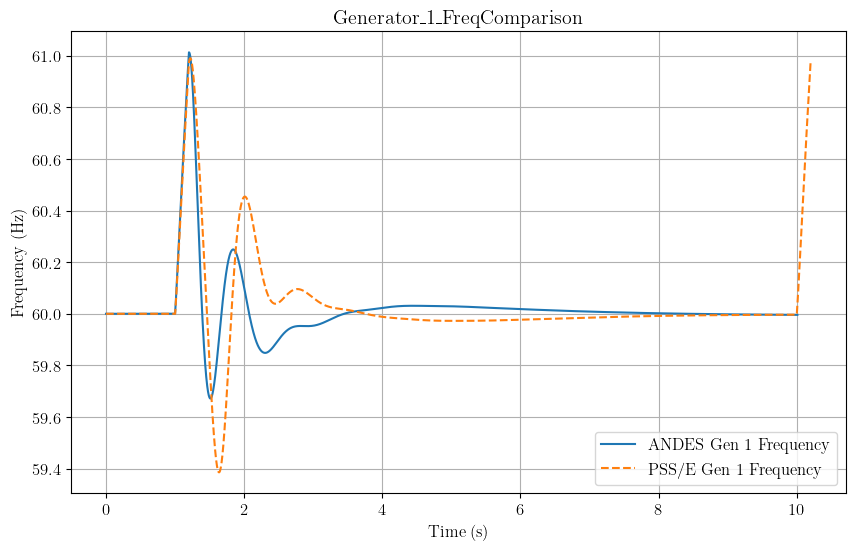

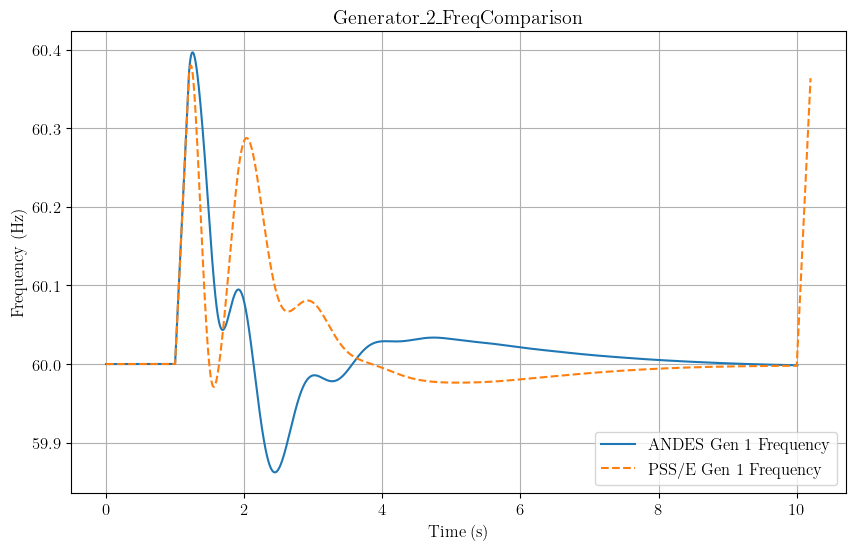

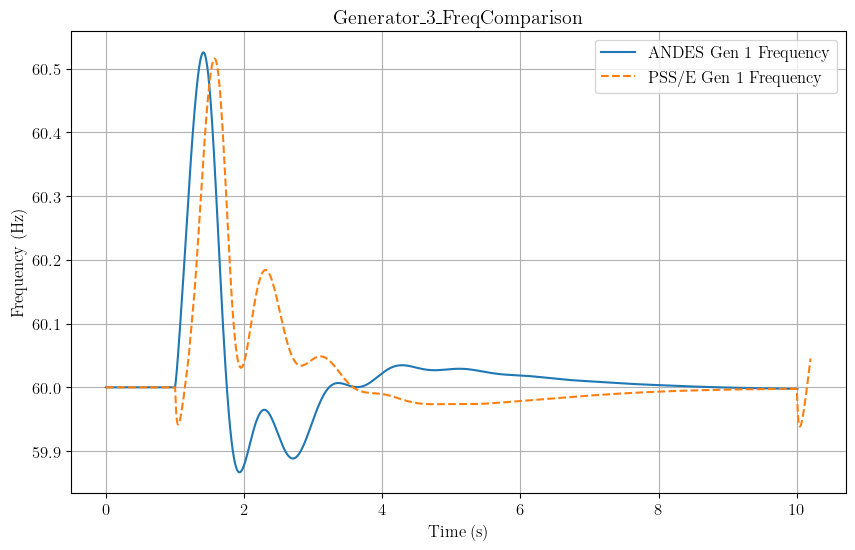

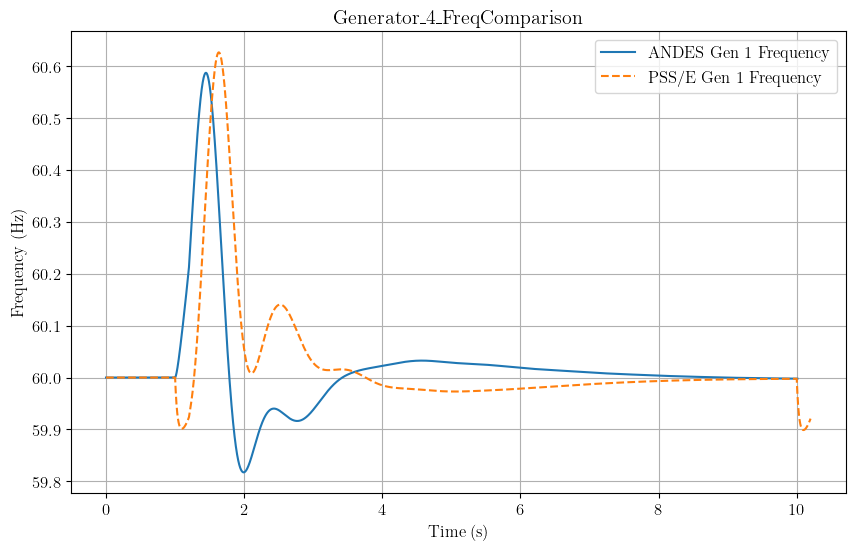

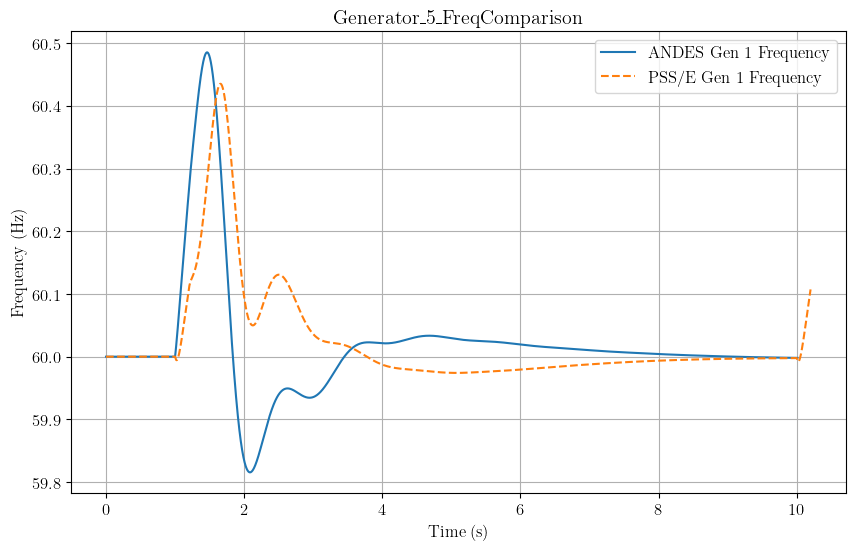

In [13]:
for i in range(1, 6):
    plot_generator_frequency(
        andes_df, psse_df, f"Generator_{i}_Freq", f"Generator_{i}_Freq"
    )

In [14]:
for i in range(1, 6):
    mae = calculate_mae_between_generators(
        andes_df.copy(), psse_df.copy(), f"Generator_{i}_Freq", f"Generator_{i}_Freq"
    )
    print(f"Mean Absolute Error (MAE) for Generator_{i}: {mae}")

Mean Absolute Error (MAE) for Generator_1: 0.06720047802829775
Mean Absolute Error (MAE) for Generator_2: 0.04892228340334828
Mean Absolute Error (MAE) for Generator_3: 0.05531945987102581
Mean Absolute Error (MAE) for Generator_4: 0.06359829610997338
Mean Absolute Error (MAE) for Generator_5: 0.055426954975352126


In [15]:
"""
potential reasons for the differences in the simulation results:

    - Governer model
        - both softwares are using the GOVT1 model for the governor and pulling from the same dyr file.
    
    - Exciter model
    
"""

'\npotential reasons for the differences in the simulation results:\n\n    - Governer model\n        - both softwares are using the GOVT1 model for the governor and pulling from the same dyr file.\n    \n    - Exciter model\n    \n'

Generating code for 97 models on 2 processes.


The honest Newton method is being used. It will slow down the simulation.
For speed up, set `honest=0` in TDS.config.


<Fault Fault_1>: Applying fault on Bus (idx=2) at t=1.0 sec.
<Fault Fault_1>: Clearing fault on Bus (idx=2) at t=1.2 sec.


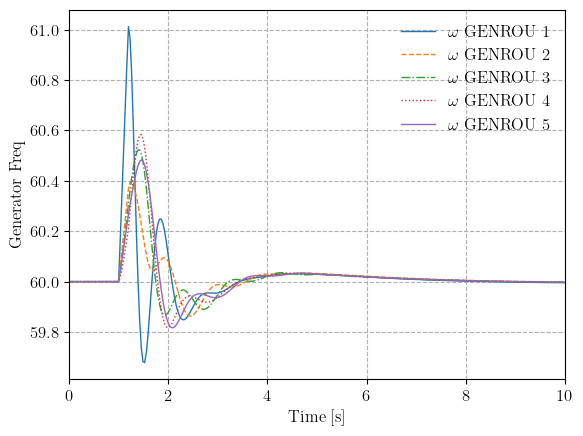

In [16]:
# review some model modification behaviors
# Flat run
case_raw_path = "./andes_IEEE14.raw"
case_dyr_path = "./andes_IEEE14.dyr"

ss_base_fault = andes.load(
    case_raw_path, addfile=case_dyr_path, codegen=True, setup=False
)

ss_base_fault.add("Fault", dict(bus=2, tf=1.0, tc=1.2))

ss_base_fault.setup()  # no `ss.add()` calls are allowed after setup()

ss_base_fault.PFlow.config.method = "NR"

ss_base_fault.PFlow.run()
ss_base_fault.TDS.config.tf = 10  # simulate for 3 mins 0 seconds to save time
ss_base_fault.TDS.config.no_tqdm = 1  # disable progres bar printing
ss_base_fault.TDS.config.method = "trapezoid"
ss_base_fault.TDS.config.honest = 1
ss_base_fault.TDS.config.qrt = 1
ss_base_fault.TDS.config.refresh_event = 1
ss_base_fault.TDS.config.linsolve = 1
ss_base_fault.TDS.tstep = 1 / 120
ss_base_fault.TDS.run()

fig, ax = ss_base_fault.TDS.plotter.plot(
    ss_base_fault.TDS.plotter.find("omega")[0],
    ycalc=lambda x: 60 * x,
    greyscale=True,
    ylabel="Generator Freq",
    grid=True,
    set_ylim=True,
)

The honest Newton method is being used. It will slow down the simulation.
For speed up, set `honest=0` in TDS.config.
Suspect initialization issue! Simulation may crash!

    Name      | Var. Value | Eqn. Mismatch
--------------+------------+--------------
 LL_y TGOV1 2 | 0.300      | 0.200        
 LL_y TGOV1 3 | 0.350      | 0.150        


Initialization failed!!
If you are developing a new model, check the initialization with
   andes -v 10 run -r tds --init ./andes_IEEE14.raw
Otherwise, check the variables that are initialized out of limits.


Old VMAX: NumParam: TGOV1.VMAX, v=[1.05, 1.05, 1.05]
Old VMIN: NumParam: TGOV1.VMIN, v=[0.3, 0.3, 0.3]
NEW VMAX: NumParam: TGOV1.VMAX, v=[1.1, 1.1, 1.1]
NEW VMIN: NumParam: TGOV1.VMIN, v=[0.5, 0.5, 0.5]


  0%|          | 0/100 [00:00<?, ?%/s]

<Fault Fault_1>: Applying fault on Bus (idx=2) at t=1.0 sec.
<Fault Fault_1>: Clearing fault on Bus (idx=2) at t=1.2 sec.


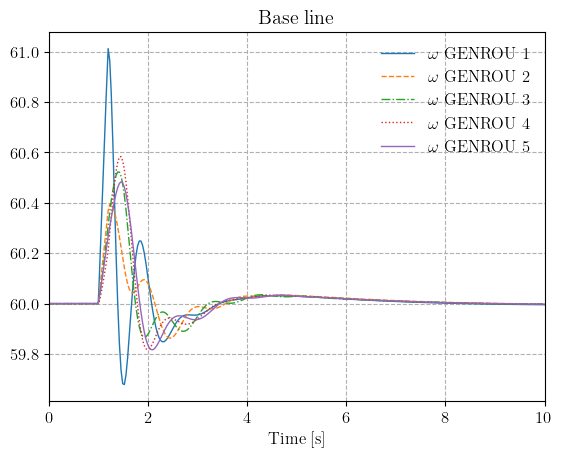

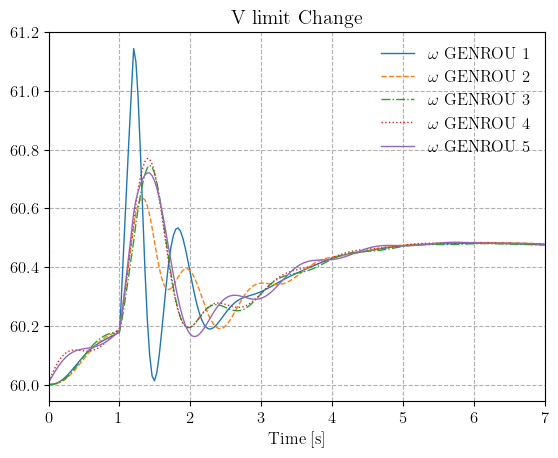

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:title={'center':'V limit Change'}, xlabel='Time [s]'>)

In [17]:
# ANDES
# Fault at bus 2 with VMAX and VMIN change
# see huge change in stability
# note that the gov is being changed here

case_raw_path = "./andes_IEEE14.raw"
case_dyr_path = "./andes_IEEE14.dyr"
ss = andes.load(case_raw_path, addfile=case_dyr_path, setup=False)


print("Old VMAX: {}".format(ss.TGOV1.VMAX))
print("Old VMIN: {}".format(ss.TGOV1.VMIN))


for i in range(len(ss.TGOV1.VMAX.v)):
    ss.TGOV1.VMAX.v[i] = 1.1

for i in range(len(ss.TGOV1.VMIN.v)):
    ss.TGOV1.VMIN.v[i] = 0.5


print("NEW VMAX: {}".format(ss.TGOV1.VMAX))
print("NEW VMIN: {}".format(ss.TGOV1.VMIN))
ss.add("Fault", dict(bus=2, tf=1.0, tc=1.2))
ss.setup()
ss.PFlow.config.method = "NR"
ss.PFlow.run()
ss.TDS.config.tf = 7
ss.TDS.config.honest = 1
ss.TDS.config.qrt = 1
ss.TDS.config.refresh_event = 1
ss.TDS.tstep = 0.001
ss.TDS.run()

ss_base_fault.TDS.plotter.plot(
    ss_base_fault.TDS.plotter.find("omega")[0],
    ycalc=lambda x: 60 * x,
    ax=ax,
    title="Base line",
    greyscale=True,
    grid=True,
)
ss.TDS.plotter.plot(
    ss.TDS.plotter.find("omega")[0],
    ycalc=lambda x: 60 * x,
    ax=ax,
    label="Baseline",
    title="V limit Change",
    greyscale=False,
    grid=True,
)

In [18]:
"""
       1 'GENROU' 1     6.5000      0.60000E-01  0.20000      0.50000E-01
          4.0000       0.0000       1.8000       1.7500      0.60000
         0.80000      0.23000      0.15000      0.90000E-01  0.38000      /
         
      1 'TGOV1'  1    0.50000E-01  0.50000E-01   1.050      0.30000
          1.0000       2.1000       0.0000      /
"""

genrou_parameters = {
    "model_name": "GENROU",  # Model name
    "T_do_prime": 1,  # T′do (>0) (sec)
    "T_do_double_prime": 2,  # T′′do (>0) (sec)
    "T_qo_prime": 3,  # T′qo (>0) (sec)
    "T_qo_double_prime": 4,  # T′′qo (>0) (sec)
    "H": 5,  # H, Inertia constant
    "D": 6,  # D, Speed damping factor
    "Xd": 7,  # Xd, Direct-axis synchronous reactance
    "Xq": 8,  # Xq, Quadrature-axis synchronous reactance
    "Xd_prime": 9,  # X′d, Direct-axis transient reactance
    "Xq_prime": 10,  # X′q, Quadrature-axis transient reactance
    "Xd_double_prime_equal": 11,  # X′′d = X′′q, Direct-axis subtransient reactance
    "Xl": 12,  # Xl, Leakage reactance
    "S_1_0": 13,  # S(1.0), Saturation factor at 1.0 per unit air-gap voltage
    "S_1_2": 14,  # S(1.2), Saturation factor at 1.2 per unit air-gap voltage
}

tgov1_parameters = {
    "model_name": "TGOV1",  # Model name
    "R": 1,  # R
    "T1": 2,  # T1 (>0) (sec)
    "VMAX": 3,  # VMAX (per unit on generator MVA base)
    "VMIN": 4,  # VMIN1 (per unit on generator MVA base)
    "T2": 5,  # T2 (sec) - high-pressure fraction
    "T3": 6,  # T3 (>0) (sec) - reheater time constant
    "DT1": 7,  # DT1 (change in throttle pressure)
}

In [19]:
# Adjust file names to include sim_num for uniqueness
output_file = f"./simulation_output_file.out"
solved_case = f"./solved_case.sav"
final_state = f"./final_state_after_dynamic_sim.sav"


for file_path in [output_file, solved_case, final_state]:
    if os.path.exists(file_path):
        print(f"Deleting existing file: {file_path}")
        os.remove(file_path)


time.sleep(2)

# Assuming case_raw_path and case_dyr_path are defined elsewhere in your script
psspy.read(1, sim_parameters["Raw"])
psspy.dyre_new(dyrefile=sim_parameters["Dyr"])
psspy.fnsl()
# psspy.save(solved_case)

# Setup for dynamic simulation
psspy.cong(0)
psspy.ordr(0)
psspy.fact()
psspy.tysl(0)
psspy.chsb(sid=0, all=1, status=[-1, -1, -1, 1, 7, 0])  # Machine speed

psspy.change_plmod_con(
    1, "1", tgov1_parameters["model_name"], tgov1_parameters["R"], 0.08
)

# Start recording to the uniquely named output file
psspy.strt_2(outfile=output_file, snapfile=solved_case)

# Set up the simulation parameters (assumed to be done correctly)
psspy.dynamics_solution_param_2(REALAR3=sim_parameters["Res"])


"""event 1 """
psspy.run(tpause=1)
psspy.dist_bus_fault(ibus=2, string="", basekv=0, busfrac=1.0, r=0.0, x=0.0)

sim_time = 1.2
psspy.run(tpause=sim_time)
psspy.dist_clear_fault(1)


# '''event 2'''
# psspy.run(tpause=10)
# psspy.dist_bus_fault(ibus=2, string="", basekv=0, busfrac=1.0, r=0.0, x=0.0)

# psspy.run(tpause=10.2)
# psspy.dist_clear_fault(1)

psspy.run(tpause=sim_parameters["Duration"])

psspy.remove_unused_chan_models()
psspy.delete_all_plot_channels()

# Save the final state to a uniquely named file
psspy.save(final_state)

Deleting existing file: ./simulation_output_file.out
Deleting existing file: ./final_state_after_dynamic_sim.sav

 Reading IC, SBASE, REV, XFRRAT, NXFRAT, BASFRQ...

 Converting RAW data from PSS(R)E 32 to PSS(R)E 33 format
 Starting processing of Case identification data records
 Finished processing of 3 records for Case identification data
 Starting processing of Bus data records
 Finished processing of 14 records for Bus data
 Starting processing of Load data records
 Finished processing of 11 records for Load data
 Starting processing of Fixed shunt data records
 Finished processing of 0 records for Fixed shunt data
 Starting processing of Generator data records
 Finished processing of 5 records for Generator data
 Starting processing of Branch data records
 Finished processing of 16 records for Branch data
 Starting processing of Transformer data records
 Finished processing of 16 records for 4 Transformer data
 Starting processing of Area data records
 Finished processing of 2 re


  0.6900 -3.07673E-08 -1.58755E-09   0.0000      2.06383E-09 -6.19146E-09

  0.6910 -3.08046E-08 -1.58985E-09   0.0000      2.06681E-09 -6.20040E-09

  0.6920 -3.08418E-08 -1.59214E-09   0.0000      2.06979E-09 -6.20934E-09

    TIME X- VALUE --X X--------- IDENTIFIER ---------X X- VALUE --X X--------- IDENTIFIER ---------X
  0.6930 -3.08791E-08 SPD      1[BUS1        69.000]1  -1.59443E-09 SPD      2[BUS2        69.000]1
     3     0.0000     SPD      3[BUS3        69.000]1   2.07277E-09 SPD      6[BUS6        138.00]1
     5   -6.21829E-09 SPD      8[BUS8        69.000]1

  0.6940 -3.09164E-08 -1.59672E-09   0.0000      2.07575E-09 -6.22723E-09

  0.6950 -3.09536E-08 -1.59902E-09   0.0000      2.07873E-09 -6.23617E-09

  0.6960 -3.09909E-08 -1.60131E-09   0.0000      2.08171E-09 -6.24511E-09

  0.6970 -3.10281E-08 -1.60360E-09   0.0000      2.08469E-09 -6.25405E-09

    TIME X- VALUE --X X--------- IDENTIFIER ---------X X- VALUE --X X--------- IDENTIFIER ---------X
  0.6980 -3.10654

  1.9300  5.65800E-03 SPD      1[BUS1        69.000]1   4.19118E-03 SPD      2[BUS2        69.000]1
     3    7.87722E-04 SPD      3[BUS3        69.000]1   2.91201E-03 SPD      6[BUS6        138.00]1
     5    3.26834E-03 SPD      8[BUS8        69.000]1

  1.9310  5.71016E-03  4.19778E-03  7.79305E-04  2.88176E-03  3.24681E-03

  1.9320  5.76184E-03  4.20433E-03  7.71101E-04  2.85165E-03  3.22533E-03

  1.9330  5.81305E-03  4.21081E-03  7.63109E-04  2.82169E-03  3.20391E-03

  1.9340  5.86378E-03  4.21723E-03  7.55327E-04  2.79187E-03  3.18255E-03

    TIME X- VALUE --X X--------- IDENTIFIER ---------X X- VALUE --X X--------- IDENTIFIER ---------X
  1.9350  5.91403E-03 SPD      1[BUS1        69.000]1   4.22358E-03 SPD      2[BUS2        69.000]1
     3    7.47755E-04 SPD      3[BUS3        69.000]1   2.76219E-03 SPD      6[BUS6        138.00]1
     5    3.16125E-03 SPD      8[BUS8        69.000]1

  1.9360  5.96381E-03  4.22988E-03  7.40393E-04  2.73267E-03  3.14001E-03

  1.9370  6.01


  3.2169  6.35227E-04  1.14667E-03  1.00379E-03  4.72919E-04  6.16618E-04

  3.2179  6.32990E-04  1.14404E-03  1.00258E-03  4.72986E-04  6.16370E-04

  3.2189  6.30771E-04  1.14140E-03  1.00136E-03  4.73059E-04  6.16125E-04

    TIME X- VALUE --X X--------- IDENTIFIER ---------X X- VALUE --X X--------- IDENTIFIER ---------X
  3.2199  6.28569E-04 SPD      1[BUS1        69.000]1   1.13875E-03 SPD      2[BUS2        69.000]1
     3    1.00012E-03 SPD      3[BUS3        69.000]1   4.73136E-04 SPD      6[BUS6        138.00]1
     5    6.15883E-04 SPD      8[BUS8        69.000]1

  3.2209  6.26385E-04  1.13611E-03  9.98866E-04  4.73219E-04  6.15644E-04

  3.2219  6.24218E-04  1.13346E-03  9.97601E-04  4.73307E-04  6.15408E-04

  3.2229  6.22068E-04  1.13081E-03  9.96321E-04  4.73400E-04  6.15174E-04

  3.2239  6.19936E-04  1.12816E-03  9.95028E-04  4.73497E-04  6.14943E-04

    TIME X- VALUE --X X--------- IDENTIFIER ---------X X- VALUE --X X--------- IDENTIFIER ---------X
  3.2249  6.17820


  4.2989 -2.10838E-04 -1.14545E-04 -1.96016E-04 -2.35558E-04 -1.99523E-04

    TIME X- VALUE --X X--------- IDENTIFIER ---------X X- VALUE --X X--------- IDENTIFIER ---------X
  4.2999 -2.11241E-04 SPD      1[BUS1        69.000]1  -1.15228E-04 SPD      2[BUS2        69.000]1
     3   -1.96801E-04 SPD      3[BUS3        69.000]1  -2.35787E-04 SPD      6[BUS6        138.00]1
     5   -1.99870E-04 SPD      8[BUS8        69.000]1

  4.3009 -2.11644E-04 -1.15911E-04 -1.97586E-04 -2.36015E-04 -2.00217E-04

  4.3019 -2.12046E-04 -1.16593E-04 -1.98369E-04 -2.36243E-04 -2.00563E-04

  4.3029 -2.12449E-04 -1.17274E-04 -1.99152E-04 -2.36471E-04 -2.00908E-04

  4.3039 -2.12852E-04 -1.17954E-04 -1.99934E-04 -2.36699E-04 -2.01253E-04

    TIME X- VALUE --X X--------- IDENTIFIER ---------X X- VALUE --X X--------- IDENTIFIER ---------X
  4.3049 -2.13254E-04 SPD      1[BUS1        69.000]1  -1.18633E-04 SPD      2[BUS2        69.000]1
     3   -2.00716E-04 SPD      3[BUS3        69.000]1  -2.36926E-04

     5   -4.20756E-04 SPD      8[BUS8        69.000]1

  5.4908 -4.71529E-04 -3.96926E-04 -4.50058E-04 -4.39536E-04 -4.20731E-04

  5.4918 -4.71538E-04 -3.96936E-04 -4.50038E-04 -4.39507E-04 -4.20705E-04

  5.4928 -4.71547E-04 -3.96945E-04 -4.50018E-04 -4.39478E-04 -4.20679E-04

  5.4938 -4.71556E-04 -3.96954E-04 -4.49997E-04 -4.39449E-04 -4.20653E-04

    TIME X- VALUE --X X--------- IDENTIFIER ---------X X- VALUE --X X--------- IDENTIFIER ---------X
  5.4948 -4.71565E-04 SPD      1[BUS1        69.000]1  -3.96963E-04 SPD      2[BUS2        69.000]1
     3   -4.49976E-04 SPD      3[BUS3        69.000]1  -4.39420E-04 SPD      6[BUS6        138.00]1
     5   -4.20626E-04 SPD      8[BUS8        69.000]1

  5.4958 -4.71573E-04 -3.96972E-04 -4.49954E-04 -4.39391E-04 -4.20600E-04

  5.4968 -4.71581E-04 -3.96980E-04 -4.49932E-04 -4.39362E-04 -4.20574E-04

  5.4978 -4.71589E-04 -3.96989E-04 -4.49909E-04 -4.39333E-04 -4.20548E-04

  5.4988 -4.71596E-04 -3.96997E-04 -4.49886E-04 -4.39303E-04 -4.


    TIME X- VALUE --X X--------- IDENTIFIER ---------X X- VALUE --X X--------- IDENTIFIER ---------X
  6.7447 -3.51321E-04 SPD      1[BUS1        69.000]1  -2.89767E-04 SPD      2[BUS2        69.000]1
     3   -3.18420E-04 SPD      3[BUS3        69.000]1  -3.15556E-04 SPD      6[BUS6        138.00]1
     5   -3.03693E-04 SPD      8[BUS8        69.000]1

  6.7457 -3.51183E-04 -2.89643E-04 -3.18281E-04 -3.15422E-04 -3.03565E-04

  6.7467 -3.51045E-04 -2.89519E-04 -3.18142E-04 -3.15288E-04 -3.03436E-04

  6.7477 -3.50907E-04 -2.89394E-04 -3.18003E-04 -3.15154E-04 -3.03308E-04

  6.7487 -3.50770E-04 -2.89270E-04 -3.17864E-04 -3.15019E-04 -3.03179E-04

    TIME X- VALUE --X X--------- IDENTIFIER ---------X X- VALUE --X X--------- IDENTIFIER ---------X
  6.7497 -3.50632E-04 SPD      1[BUS1        69.000]1  -2.89146E-04 SPD      2[BUS2        69.000]1
     3   -3.17725E-04 SPD      3[BUS3        69.000]1  -3.14885E-04 SPD      6[BUS6        138.00]1
     5   -3.03051E-04 SPD      8[BUS8     


  8.0306 -1.93927E-04 -1.48883E-04 -1.63867E-04 -1.63130E-04 -1.56556E-04

  8.0316 -1.93829E-04 -1.48799E-04 -1.63772E-04 -1.63037E-04 -1.56466E-04

  8.0326 -1.93731E-04 -1.48715E-04 -1.63677E-04 -1.62944E-04 -1.56377E-04

  8.0336 -1.93634E-04 -1.48630E-04 -1.63583E-04 -1.62851E-04 -1.56287E-04

    TIME X- VALUE --X X--------- IDENTIFIER ---------X X- VALUE --X X--------- IDENTIFIER ---------X
  8.0346 -1.93536E-04 SPD      1[BUS1        69.000]1  -1.48546E-04 SPD      2[BUS2        69.000]1
     3   -1.63488E-04 SPD      3[BUS3        69.000]1  -1.62757E-04 SPD      6[BUS6        138.00]1
     5   -1.56197E-04 SPD      8[BUS8        69.000]1

  8.0356 -1.93439E-04 -1.48462E-04 -1.63394E-04 -1.62664E-04 -1.56107E-04

  8.0366 -1.93342E-04 -1.48378E-04 -1.63299E-04 -1.62571E-04 -1.56018E-04

  8.0376 -1.93244E-04 -1.48293E-04 -1.63205E-04 -1.62478E-04 -1.55928E-04

  8.0386 -1.93147E-04 -1.48209E-04 -1.63110E-04 -1.62385E-04 -1.55839E-04

    TIME X- VALUE --X X--------- IDENTIFIER


  9.3481 -1.01729E-04 -7.26588E-05 -7.75037E-05 -7.81935E-05 -7.52949E-05

  9.3491 -1.01684E-04 -7.26248E-05 -7.74638E-05 -7.81544E-05 -7.52574E-05

    TIME X- VALUE --X X--------- IDENTIFIER ---------X X- VALUE --X X--------- IDENTIFIER ---------X
  9.3501 -1.01639E-04 SPD      1[BUS1        69.000]1  -7.25909E-05 SPD      2[BUS2        69.000]1
     3   -7.74239E-05 SPD      3[BUS3        69.000]1  -7.81153E-05 SPD      6[BUS6        138.00]1
     5   -7.52200E-05 SPD      8[BUS8        69.000]1

  9.3511 -1.01595E-04 -7.25570E-05 -7.73842E-05 -7.80762E-05 -7.51826E-05

  9.3521 -1.01550E-04 -7.25231E-05 -7.73445E-05 -7.80371E-05 -7.51452E-05

  9.3531 -1.01505E-04 -7.24891E-05 -7.73048E-05 -7.79981E-05 -7.51079E-05

  9.3541 -1.01461E-04 -7.24552E-05 -7.72653E-05 -7.79592E-05 -7.50706E-05

    TIME X- VALUE --X X--------- IDENTIFIER ---------X X- VALUE --X X--------- IDENTIFIER ---------X
  9.3552 -1.01416E-04 SPD      1[BUS1        69.000]1  -7.24213E-05 SPD      2[BUS2        6

0

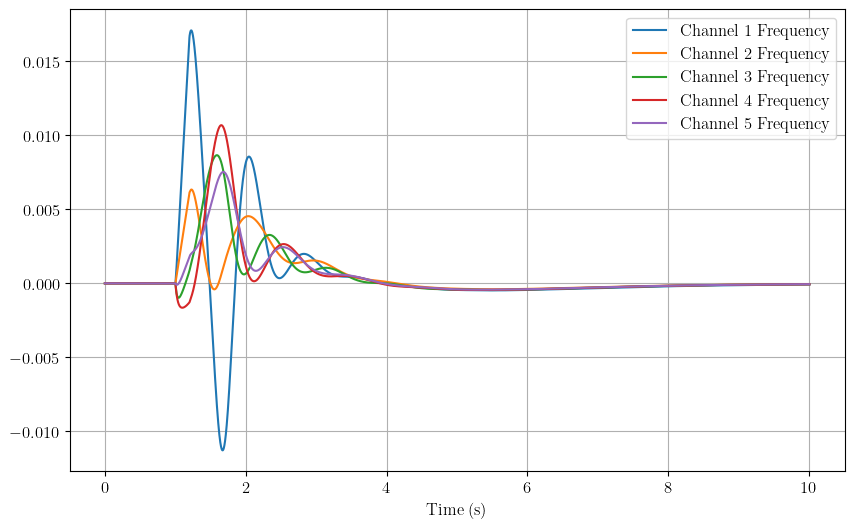

<module 'matplotlib.pyplot' from 'C:\\Users\\alexb\\miniconda3\\envs\\PSSe\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [20]:
plot_temp(output_file, channels=[1, 2, 3, 4, 5])

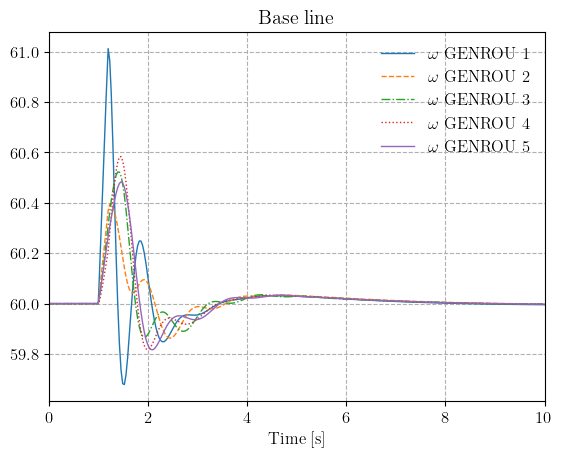

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:title={'center':'Base line'}, xlabel='Time [s]'>)

In [21]:
ss_base_fault.TDS.plotter.plot(
    ss_base_fault.TDS.plotter.find("omega")[0],
    ycalc=lambda x: 60 * x,
    ax=ax,
    title="Base line",
    greyscale=True,
    grid=True,
)